# Import modules

In [1]:
import cv2
import sys
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix,classification_report
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Split the data set as train and test data set

In [2]:
csvfile = pd.read_csv('tensorflow-great-barrier-reef/train.csv')
print(csvfile)

       video_id  sequence  video_frame  sequence_frame image_id annotations
0             0     40258            0               0      0-0          []
1             0     40258            1               1      0-1          []
2             0     40258            2               2      0-2          []
3             0     40258            3               3      0-3          []
4             0     40258            4               4      0-4          []
...         ...       ...          ...             ...      ...         ...
23496         2     29859        10755            2983  2-10755          []
23497         2     29859        10756            2984  2-10756          []
23498         2     29859        10757            2985  2-10757          []
23499         2     29859        10758            2986  2-10758          []
23500         2     29859        10759            2987  2-10759          []

[23501 rows x 6 columns]


In [3]:
csvfile = csvfile.sample(frac=1).reset_index(drop=True)
print(csvfile)

       video_id  sequence  video_frame  sequence_frame image_id  \
0             2     37114          892             892    2-892   
1             2     37114         1962            1962   2-1962   
2             2     26651         3735              63   2-3735   
3             1      8503         6343            2515   1-6343   
4             2     29859        10720            2948  2-10720   
...         ...       ...          ...             ...      ...   
23496         2     37114          847             847    2-847   
23497         2     29859         8344             572   2-8344   
23498         1     60754        10724            2308  1-10724   
23499         0     40258          269             269    0-269   
23500         2     26651         4176             504   2-4176   

                                             annotations  
0                                                     []  
1                                                     []  
2                 

In [4]:
print(csvfile.shape[0])
split_point = int(0.8*csvfile.shape[0])

23501


In [5]:
train_data = csvfile[0:split_point]
test_data=csvfile[split_point:csvfile.shape[0]].reset_index(drop=True)
print(len(train_data))
print(len(test_data))

18800
4701


In [7]:
empty_num = 0
nonempty_num = 0
for i in range(0,len(csvfile)):
    row = csvfile.iloc[i]
    if row['annotations'] != '[]':
        nonempty_num = nonempty_num + 1
    elif row['annotations'] == '[]':
        empty_num = empty_num + 1
print(empty_num,nonempty_num)

18582 4919


# Get hog descriptor of starfish area in train data set

In [8]:
positive_descriptors = []
for i in range(0,len(train_data)):
    row = train_data.iloc[i]
    if row['annotations'] != '[]':
        path = f"tensorflow-great-barrier-reef/train_images/video_{row['video_id']}/{row['video_frame']}.jpg"
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for element in eval(row['annotations']):
            x_coordinate = element['x']
            y_coordinate = element['y']
            width = element['width']
            height = element['height']
            starfish_image = img[y_coordinate:y_coordinate+height,x_coordinate:x_coordinate+width]
    #         label_area =cv2.rectangle(img, (x_corrdinate,y_coordinate), (x_coordinate+width,y_corrdinate+height), (255,0,0), 2)
    #         plt.imshow(label_area)
    # Get the hog descriptor in 40 * 40 window
            starfish_image = cv2.resize(starfish_image, (40, 40))
            hog_vector = hog(starfish_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
            positive_descriptors.append(hog_vector.tolist())
print(len(positive_descriptors))

9438


# Get negative samples(background) in train data set

In [9]:
# Get negative samples in four direction surrounding the starfish rectangle
def border_negative(x,y,width,height,image_width,image_height,window_size,img):
    top = []
    bottom = []
    left = []
    right = []
    if x >= window_size - 1: # Left available
        left = img[min(y,image_height - 1 - window_size):min(y,image_height - 1 - window_size) + window_size,x + 1 - window_size: x + 1]
    if x + width + window_size <= image_width - 1: # Right
        right = img[min(y,image_height - 1 - window_size):min(y,image_height - 1 - window_size) + window_size, x + width: x + width + window_size]
    if y >= window_size - 1: # Top
        top = img[y + 1 - window_size: y + 1,min(x,image_width - 1 - window_size):min(x,image_width - 1 - window_size) + window_size]
    if y + height + window_size <= image_height - 1: # Bottom
        bottom = img[y + height: y + height + window_size,min(x,image_width - 1 - window_size):min(x,image_width - 1 - window_size) + window_size]
    return top, bottom, left, right

In [10]:
count = 0
negative_descriptors = []
for i in range(0,len(train_data)):
    row = train_data.iloc[i]
    if row['annotations'] != '[]':
        path = f"tensorflow-great-barrier-reef/train_images/video_{row['video_id']}/{row['video_frame']}.jpg"
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for element in eval(row['annotations']):
            x_coordinate = element['x']
            y_coordinate = element['y']
            width = element['width']
            height = element['height']
            top, bottom, left, right = border_negative(x_coordinate,y_coordinate,width,height,img.shape[1],img.shape[0],40,img)
            if len(top):
                top_vector = hog(top, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
                negative_descriptors.append(top_vector.tolist())
            if len(bottom):
                bottom_vector = hog(bottom, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
                negative_descriptors.append(bottom_vector.tolist())
            if len(left):
                left_vector = hog(left, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
                negative_descriptors.append(left_vector.tolist())
            if len(right):
                right_vector = hog(right, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
                negative_descriptors.append(right_vector.tolist())
print(len(negative_descriptors))

36311


In [12]:
# Get negative samples in other images which has no starfish exists. Only sample the background part
bg_descriptors = []
count = 0
for i in range(0,len(train_data)):
    row = train_data.iloc[i]
    if row['annotations'] == '[]':
        path = f"tensorflow-great-barrier-reef/train_images/video_{row['video_id']}/{row['video_frame']}.jpg"
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for i in range(0,2): # two samples per image
            x = random.randint(0,img.shape[1] - 40)
            y = random.randint(0,img.shape[0] - 40)
            bg_img = img[y:y+40,x:x+40]
            bg_vector = hog(bg_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
            bg_descriptors.append(bg_vector.tolist())
print(len(bg_descriptors))

29676


# Model training and testing

In [13]:
random.shuffle(negative_descriptors)
random.shuffle(bg_descriptors)

In [14]:
negative_descriptors = negative_descriptors[0:len(positive_descriptors)]
bg_descriptors = bg_descriptors[0:len(positive_descriptors)]
print(len(negative_descriptors))
print(len(bg_descriptors))
negative_descriptors.extend(bg_descriptors)
print(len(negative_descriptors))

9438
9438
18876


In [15]:
Y = [1]*len(positive_descriptors)
Y.extend([0]*len(negative_descriptors))
Y = np.array(Y)
X = positive_descriptors
X.extend(negative_descriptors)
X = np.array(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [16]:
# Set probalility as confidence value.
clf = SVC(probability=True)
clf.fit(X_train,Y_train)
SVM_predict = clf.predict(X_test)
print(classification_report(Y_test,SVM_predict))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3751
           1       0.91      0.86      0.89      1912

    accuracy                           0.93      5663
   macro avg       0.92      0.91      0.92      5663
weighted avg       0.92      0.93      0.92      5663



# Test out model in real image

In [22]:
# Referenced from https://blog.csdn.net/submarineas/article/details/124512591?spm=1001.2101.3001.6650.15&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-15-124512591-blog-114372152.pc_relevant_recovery_v2&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-15-124512591-blog-114372152.pc_relevant_recovery_v2&utm_relevant_index=21
# Use Non-maximum suppression to decrease the rectangles shown in the image
def NMS(boxes, threshold):
    if len(boxes) == 0:
        return [] 
    boxes = np.array(boxes).astype("float")
    x1 = boxes[:,0]  
    y1 = boxes[:,1]	
    w1 = boxes[:,2]  
    h1 = boxes[:,3] 
    x2 = x1 + w1  
    y2 = y1 + h1  
    area = (w1 + 1) * (h1 + 1)
    temp = []  
    idxs = np.argsort(h1) 
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        temp.append(i)   
        x1_m = np.maximum(x1[i], x1[idxs[:last]])
        y1_m = np.maximum(y1[i], y1[idxs[:last]])     
        x2_m = np.minimum(x2[i], x2[idxs[:last]])
        y2_m = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, x2_m - x1_m + 1)
        h = np.maximum(0, y2_m - y1_m + 1)      
        over = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(over > threshold)[0]))) 
    return boxes[temp].astype("int")

In [23]:
# Calculate the IOU used in F2 score calculation
def IOU_coco(bbox1, bbox2):
    '''
        adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    '''
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y_bottom = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = bbox1[2] * bbox1[3]
    bb2_area = bbox2[2] * bbox2[3]
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [24]:
TP = []
FP = []
FN = 0

In [25]:
# Calculate the f2 score per image
def f2(gt,boxes,threshold):
    # gt = [[x1,y1,w1,h1],[x2,y2,w2,h2]...]
    # boxes = [[x,y,w,h,confidence]....]
    # thresholds ranging from 0.3 to 0.8 at 0.05 increments, and we then use the average as the metric for the main leaderboard.
    global FN
    boxes.sort(key = lambda x: x[4], reverse = True)
    if len(gt) == 0:
        for box in boxes:
            FP.append(box[4])
    else:
        for box in boxes:
            highest_iou = 0
            max_index = 0
            for i in range(0,len(gt)):
                if len(gt[i]) == 4:
                    iou = IOU_coco(box,gt[i])
                    if iou > highest_iou:
                        highest_iou = iou
                        max_index = i
            if highest_iou > threshold:
                TP.append(box[4])
            else:
                FP.append(box[4])
            gt[max_index].append('Matched')
        for gt_box in gt:
            if len(gt_box) == 4:
                FN = FN + 1
    return 0

In [28]:
import datetime
start = datetime.datetime.now()
for i in range(0,100): 
    location = []
    boxes = []
    gt = []
    row = test_data.iloc[i]
    path = f"tensorflow-great-barrier-reef/train_images/video_{row['video_id']}/{row['video_frame']}.jpg"
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height = img.shape[0]
    width = img.shape[1]
    # Use the minimum size as a threshold for image pyramid
    minimum_size = (500,500)
    ratio = 1.8
    if row['annotations'] != '[]':
        for element in eval(row['annotations']):
            gt_x = element['x']
            gt_y = element['y']
            gt_w = element['width']
            gt_h = element['height']
            gt.append([gt_x,gt_y,gt_w,gt_h])
    else:
        pass
    while img.shape[0] >= minimum_size[0] and img.shape[1] >= minimum_size[1]:
        h = img.shape[0]
        w = img.shape[1]
        # Set step size as 8, smaller setp size will give us more prediction results and longer running time
        for i in range(0,w - 40,8):
            for j in range(0,h - 40,8):
                slice_img = img[j:j+40,i:i+40]
                slice_vector = hog(slice_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
                result = clf.predict(np.array([slice_vector]))
                if result[0] == 1:
                    p = max(clf.predict_proba(np.array([slice_vector]))[0])
                    x = int(width/w*i)
                    y = int(height/h*j)
                    img_h = int(height/h*40)
                    img_w = int(width/w*40)
                    boxes.append([x,y,img_w,img_h,p])
                    # Only show the rectangles which has high confidence
                    if p >= 0.95:
                        location.append([x,y,img_w,img_h])
        # Coordiante transformation after image pyramid
        (new_w,new_h) = (int(w/ratio),int(h/ratio))
        img = cv2.resize(img,(new_w,new_h))
    f2(gt,boxes,0.3)
end = datetime.datetime.now()
print('Time used is ', end - start)
# for element in NMS(location,0.1):
#     count = count + 1
#     cv2.rectangle(img_rgb,(element[0],element[1]),(element[0]+element[2],element[1]+element[3]), (255,0,0), 2)
# plt. figure(figsize = (256,100))
# plt.imshow(img_rgb)

Time used is  3:37:13.037361


# Take one test image as an example

In [39]:
count = 0
row = test_data.iloc[5]
path = f"tensorflow-great-barrier-reef/train_images/video_{row['video_id']}/{row['video_frame']}.jpg"
location = []
img = cv2.imread(path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height = img.shape[0]
width = img.shape[1]
minimum_size = (500,500)
ratio = 1.8
while img.shape[0] >= minimum_size[0] and img.shape[1] >= minimum_size[1]:
    h = img.shape[0]
    w = img.shape[1]
    for i in range(0,w - 40,8):
        for j in range(0,h - 40,8):
            slice_img = img[j:j+40,i:i+40]
            slice_vector = hog(slice_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), feature_vector=True)
            result = clf.predict(np.array([slice_vector]))
            if result[0] == 1:
                p = max(clf.predict_proba(np.array([slice_vector]))[0])
                x = int(width/w*i)
                y = int(height/h*j)
                img_h = int(height/h*40)
                img_w = int(width/w*40)
                if p >= 0.95:
                    location.append([x,y,img_w,img_h])
    (new_w,new_h) = (int(w/ratio),int(h/ratio))
    img = cv2.resize(img,(new_w,new_h))
for element in NMS(location,0.1):
    count = count + 1
    cv2.rectangle(img_rgb,(element[0],element[1]),(element[0]+element[2],element[1]+element[3]), (255,0,0), 2)
plt. figure(figsize = (256,100))
img_str = f'{count} boxes'
plt.text(1150,650,img_str,size = 250)
plt.imshow(img_rgb)

# F2 score

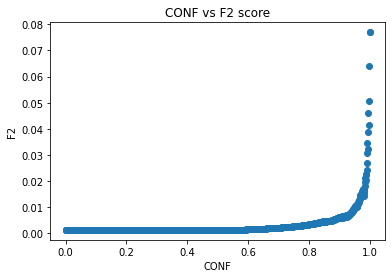

F2 max is 0.07692307692307693 at CONF = 0.998


In [50]:
# Reference from https://www.kaggle.com/code/locbaop/systematic-evaluate-f2-yolov5/notebook
F2list = []
F2max = 0.0
F2maxat = -1.0

for c in np.arange(0.0, 1.0, 0.001):
    FNcount = FN + sum(1 for i in TP if i < c)
    TPcount = sum(1 for i in TP if i >= c)
    FPcount = sum(1 for i in FP if i >= c)
    R = TPcount / (TPcount + FNcount)
    P = TPcount / (TPcount + FPcount )
    F2 = (5 * P * R) / (4 * P + R + FN)
    F2list.append((c, F2))
    if F2max < F2:
        F2max = F2
        F2maxat = c

plt.scatter(*zip(*F2list))
plt.title("CONF vs F2 score")
plt.xlabel('CONF')
plt.ylabel('F2')
plt.show()

print(f'F2 max is {F2max} at CONF = {F2maxat}')
